In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import paderbox as pb
import torch

from padertorch.base import Model
from pathlib import Path
from sklearn import datasets

/net/home/rautenberg/Schreibtisch/pvq_manipulation/.pvq_manipulation_new/lib/python3.11/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return torch._C._cuda_getDeviceCount() > 0


# load model

In [7]:
STORAGE_ROOT = Path(os.getenv('STORAGE_ROOT')).expanduser()

model_name = "toy_example_normalizing_flow/143"
model_dict = pb.io.load_yaml(STORAGE_ROOT / model_name / "config.yaml")

model = Model.from_config(model_dict['trainer']['model'])
cp = torch.load(
    STORAGE_ROOT / model_name / "checkpoints/ckpt_best_loss.pth",
    map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    weights_only=False
)

model.time_deriv_func.train_flag=False

# remove speaker encoder
model_weights = cp.copy()
model.load_state_dict(model_weights['model'])
model.eval()

CCNF(
  size=ModelParameterSize(total_count=17418, trainable_count=17418, total_bytes=69672, trainable_bytes=69672)
  (time_deriv_func): ODEBlock(
    (time_deriv_func): MLP(
      (layers): ModuleList(
        (0): Linear(in_features=4, out_features=128, bias=True)
        (1): Tanh()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Tanh()
        (4): Linear(in_features=128, out_features=2, bias=True)
      )
    )
  )
  (input_norm): MovingBatchNorm1d(2, eps=0.0001, decay=0.1, bn_lag=0, affine=True)
  (output_norm): MovingBatchNorm1d(2, eps=0.0001, decay=0.1, bn_lag=0, affine=True)
)

# Data distribution

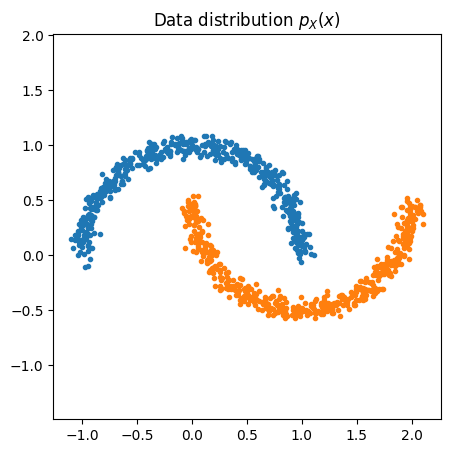

In [11]:
def plot_distribution(data, labels, title):
    fig = plt.figure(figsize=(5,5))
    plt.title(title)
    if labels is None:
        plt.plot(data[:,0], data[:,1], '.')
    else:
        plt.plot(data[:,0][labels==0], data[:,1][labels==0], '.')
        plt.plot(data[:,0][labels==1], data[:,1][labels==1], '.')
    plt.axis('equal')
    plt.show()

# create dataset
x, y = datasets.make_moons(n_samples=1000, noise=.05)

plot_distribution(
    x, 
    y, 
    title='Data distribution $p_X(x)$',
)

# Transformation from data distribution to base distribution
$z=f(x, c)$ with condition $c$

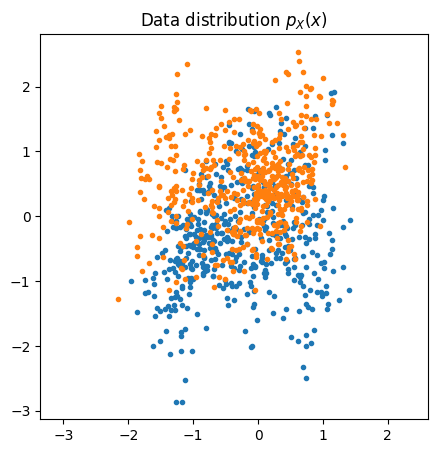

In [12]:
with torch.no_grad():
    z, _, _ = model.forward(
        (torch.tensor(x).float(), torch.tensor(y)[:,None])
    )
plot_distribution(
    z, 
    y, 
    title='Data distribution $p_X(x)$',
)

# Transformation from base distribution to target distribution
$x = f^{-1}(z, c)$ with condition $c$

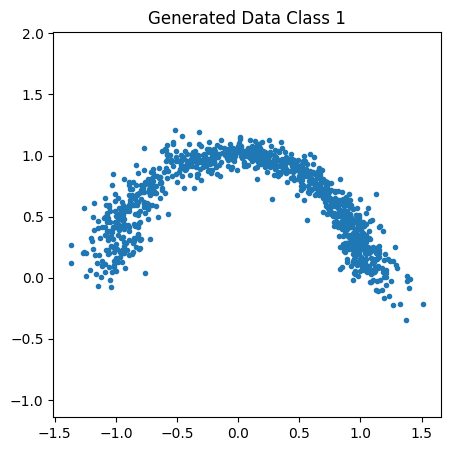

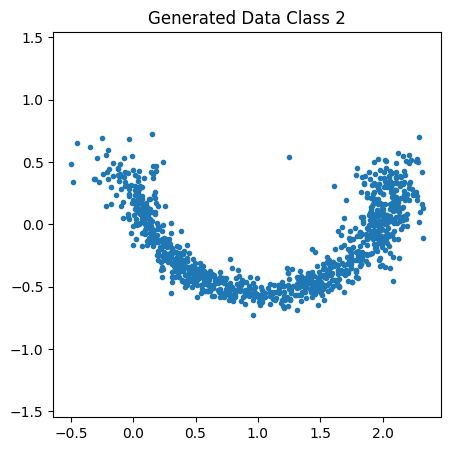

In [13]:
# base distribution is a unit gaussian
base_mean = torch.tensor([0,0], dtype=torch.float)
base_std = torch.tensor([[1.0,0],[0,1]], dtype=torch.float)
base = np.random.multivariate_normal(base_mean, base_std, 1000)

class_1_labels = torch.zeros(base.shape[0])
class_2_labels = torch.ones(base.shape[0])

with torch.no_grad():
    generated_class_1, _, _ = model.sample(
        (torch.tensor(base, dtype=torch.float), class_1_labels[:, None]), 
    )

    generated_class_2, _, _ = model.sample(
        (torch.tensor(base, dtype=torch.float), class_2_labels[:, None])
    )
plot_distribution(generated_class_1, None, "Generated Data Class 1")
plot_distribution(generated_class_2, None, "Generated Data Class 2")